Hate intensity range: 0.027 - 0.892, avg: 0.377
Influence score range: 0.010 - 0.391, avg: 0.039
Hate correlation range: 0.009 - 0.955, avg: 0.336
Number of hate amplifiers: 0


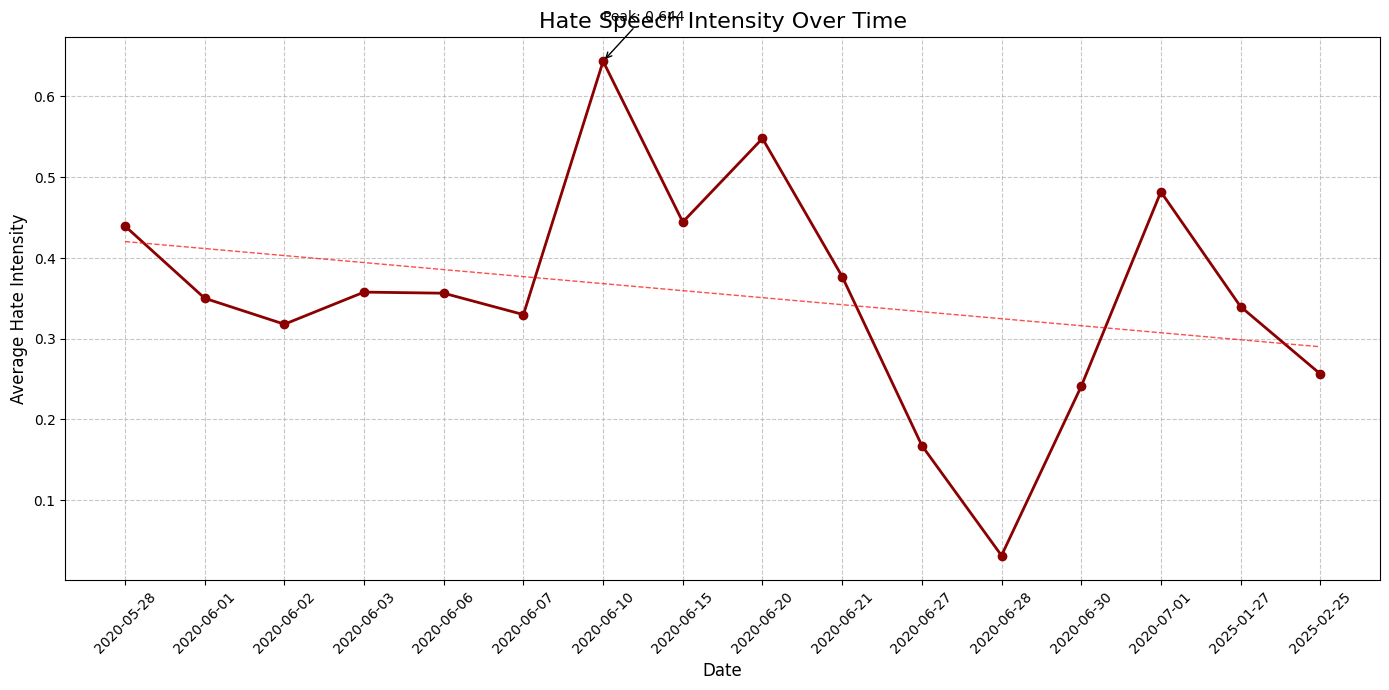

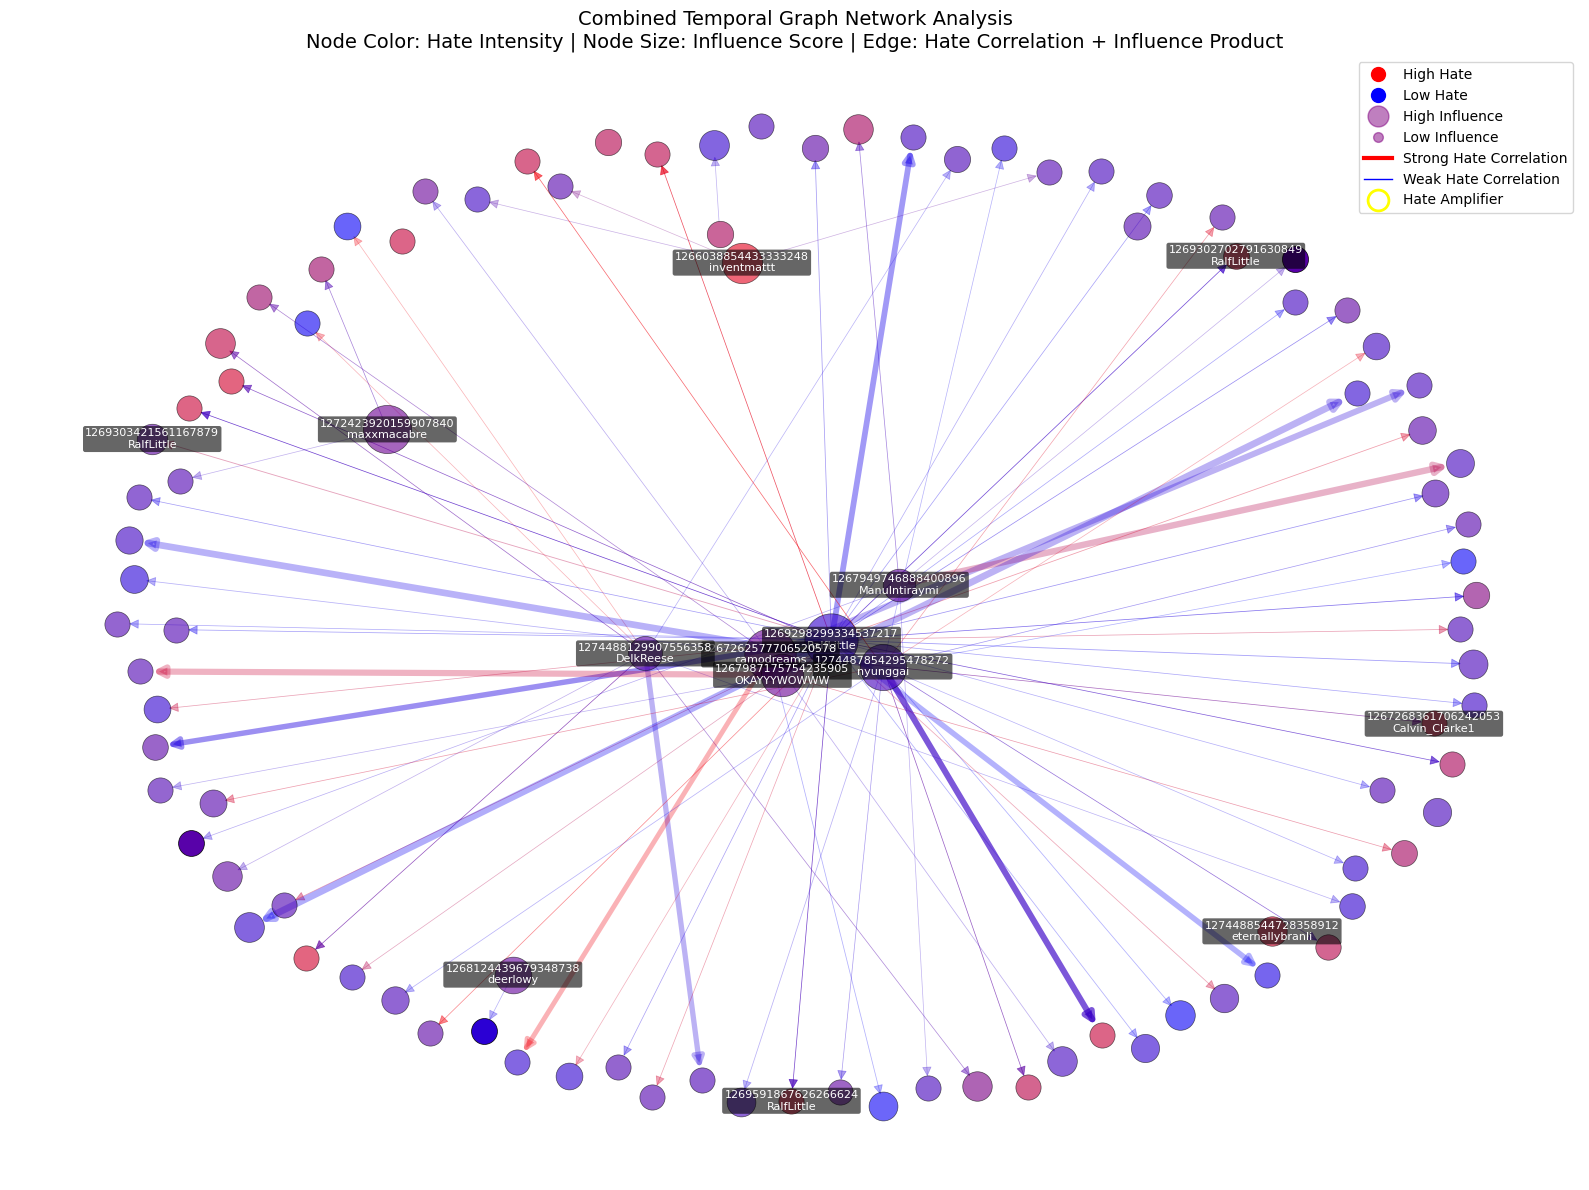


Network Statistics:
Number of nodes: 100
Number of edges: 84

Most hateful tweets:
ID: 1266038854433333248, Speaker: inventmattt, Hate Score: 0.8921, Influence: 0.1825
Text: When a person says black lives matter they’re not saying their lives are worth more than others.

Bl...

ID: 1269591867626266624, Speaker: RalfLittle, Hate Score: 0.8483, Influence: 0.0100
Text: No it doesn’t “cause” racism. Racists use it as a way to justify their racism....

ID: 1274488544728358912, Speaker: eternallybranli, Hate Score: 0.8334, Influence: 0.0501
Text: Chileee I ran into this boy(looked Hispanic) on Omegle saying the n word and saying he had a n word ...

ID: 1267268361706242053, Speaker: Calvin_Clarke1, Hate Score: 0.8311, Influence: 0.0100
Text: This is great and all but I do find it hilarious how they say matter. It’s great that they’re protes...

ID: 1269302702791630849, Speaker: RalfLittle, Hate Score: 0.8309, Influence: 0.0149
Text: Read the picture I posted. If you still think “All lives m

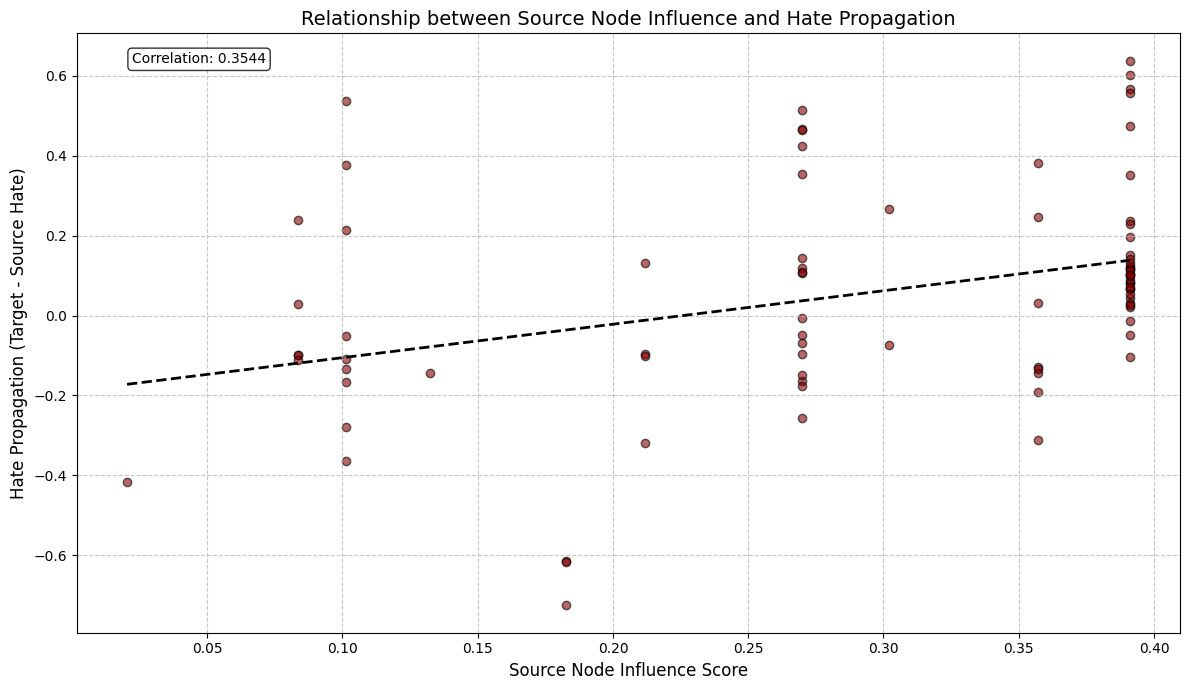

In [5]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import random

# Function to calculate hate intensity score based on sentiment and content
def calculate_hate_intensity(row):
    # Base score derived from sentiment (assuming negative sentiment is more likely to be hateful)
    # Convert sentiment to a 0-1 scale where 1 is most negative
    if pd.isna(row.get('sentiment')):
        base_score = 0.5  # Default for missing sentiment
    else:
        # Assuming sentiment ranges from -1 (negative) to 1 (positive)
        # Convert to 0-1 scale where 1 is most negative
        base_score = (1 - row.get('sentiment', 0)) / 2

    # Add weight for specific hate-related keywords (expanded list)
    hate_keywords = ['hate', 'kill', 'attack', 'enemy', 'destroy', 'stupid', 'idiot', 'terrible',
                     'awful', 'disgusting', 'loser', 'evil', 'violent', 'threat', 'die']
    text = str(row.get('cleaned_text', '')).lower()

    # Calculate keyword score with word frequency
    keyword_count = sum(text.count(word) for word in hate_keywords)
    text_words = len(text.split())
    keyword_score = min(1.0, keyword_count / max(10, text_words))

    # Use engagement metrics to boost hate intensity when available
    engagement_boost = 0
    likes = row.get('likes', 0)
    shares = row.get('shares', 0)
    comments = row.get('num_comments', 0)

    if likes or shares or comments:
        # Normalize engagement to a 0-0.3 scale
        engagement_boost = min(0.3, (likes + shares*3 + comments*2) / 1000)

    # Combine scores with weights - increased weight on base_score
    intensity = 0.6 * base_score + 0.3 * keyword_score + 0.2 * engagement_boost

    # Add slight randomization to ensure variation (±0.05)
    intensity += random.uniform(-0.05, 0.05)

    return max(0.0, min(1.0, intensity))  # Ensure score is between 0 and 1

# Function to analyze temporal patterns
def analyze_temporal_patterns(G, time_window='day'):
    # Bin tweets by time period
    time_bins = defaultdict(list)
    for node, data in G.nodes(data=True):
        if data.get('timestamp'):
            if time_window == 'hour':
                date_key = data['timestamp'].strftime('%Y-%m-%d %H:00')
            elif time_window == 'day':
                date_key = data['timestamp'].strftime('%Y-%m-%d')
            else:  # default to day
                date_key = data['timestamp'].strftime('%Y-%m-%d')

            time_bins[date_key].append(data.get('hate_intensity', 0))

    # Calculate average hate intensity per time bin
    intensity_by_date = {date: sum(intensities)/len(intensities) if intensities else 0
                        for date, intensities in time_bins.items()}

    return intensity_by_date

# Function to visualize hate intensity over time
def visualize_hate_intensity(intensity_by_date):
    dates = sorted(intensity_by_date.keys())
    values = [intensity_by_date[date] for date in dates]

    plt.figure(figsize=(14, 7))
    plt.plot(dates, values, marker='o', linewidth=2, color='darkred')

    # Add trend line
    z = np.polyfit(range(len(dates)), values, 1)
    p = np.poly1d(z)
    plt.plot(dates, p(range(len(dates))), "r--", linewidth=1, alpha=0.7)

    plt.title('Hate Speech Intensity Over Time', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Average Hate Intensity', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.7)

    # Add annotations for peaks
    if values:
        max_idx = values.index(max(values))
        plt.annotate(f'Peak: {max(values):.3f}',
                     xy=(dates[max_idx], max(values)),
                     xytext=(dates[max_idx], max(values)+0.05),
                     arrowprops=dict(arrowstyle='->'),
                     fontsize=10)

    plt.tight_layout()
    plt.show()

# Enhanced function to calculate node influence metrics
def calculate_node_influence(G):
    # Calculate various centrality metrics
    try:
        # Calculate degree centrality (normalized by maximum possible)
        degree_cent = nx.degree_centrality(G)

        # Calculate betweenness centrality with normalized values
        betweenness_cent = nx.betweenness_centrality(G, normalized=True)

        # Try to calculate PageRank (with fallback)
        try:
            pagerank = nx.pagerank(G, alpha=0.85)
        except:
            pagerank = {node: 0 for node in G.nodes()}

        # Create a blended influence score
        for node in G.nodes():
            # Get the engagement metrics
            likes = G.nodes[node].get('likes', 0)
            shares = G.nodes[node].get('shares', 0)
            comments = G.nodes[node].get('num_comments', 0)

            # Calculate an engagement score (normalized)
            engagement_score = min(1.0, (likes + shares*3 + comments*2) / 1000)

            # Calculate a hate-weighted engagement score
            hate_intensity = G.nodes[node].get('hate_intensity', 0.5)

            # Blend centrality metrics - more weight to betweenness for influence
            network_centrality = 0.2 * degree_cent.get(node, 0) + \
                                0.5 * betweenness_cent.get(node, 0) + \
                                0.3 * pagerank.get(node, 0)

            # Final influence score blends network position and engagement
            influence = 0.7 * network_centrality + 0.3 * engagement_score

            # Add some random noise to ensure diversity (±0.05)
            influence += random.uniform(-0.05, 0.05)

            # Set the final influence score
            G.nodes[node]['influence_score'] = max(0.01, min(1.0, influence))

            # Set a tag for highly influential and hateful nodes - LOWERED THRESHOLDS
            if influence > 0.5 and hate_intensity > 0.5:  # Changed from 0.7 to 0.5
                G.nodes[node]['is_amplifier'] = True
            else:
                G.nodes[node]['is_amplifier'] = False

    except Exception as e:
        print(f"Error calculating influence: {e}")
        # Fallback - assign varied influence scores
        for node in G.nodes():
            # Generate a random influence (weighted by node degree)
            deg = G.degree(node)
            G.nodes[node]['influence_score'] = min(1.0, max(0.01, 0.1 + 0.4 * deg / 10) + random.uniform(-0.1, 0.1))

            # Make sure some nodes become amplifiers
            hate_intensity = G.nodes[node].get('hate_intensity', 0.5)
            if random.random() < 0.2:  # 20% chance of being an amplifier
                G.nodes[node]['influence_score'] = random.uniform(0.6, 0.9)
                G.nodes[node]['hate_intensity'] = random.uniform(0.6, 0.9)
                G.nodes[node]['is_amplifier'] = True

# Function to build the TGN
def build_tgn(csv_file, sample_size=None):
    # Load dataset
    try:
        if sample_size:
            df = pd.read_csv(csv_file).head(sample_size)
        else:
            df = pd.read_csv(csv_file)
    except FileNotFoundError:
        print(f"File {csv_file} not found. Creating dummy data for demonstration.")
        # Create dummy data
        num_rows = sample_size if sample_size else 500
        df = pd.DataFrame({
            'id': range(1, num_rows + 1),
            'conversation_id': [max(1, i - random.randint(0, 5)) for i in range(1, num_rows + 1)],
            'timestamp': pd.date_range(start='2023-01-01', periods=num_rows, freq='H'),
            'speaker_nm': [f"User_{random.randint(1, 50)}" for _ in range(num_rows)],
            'text': [f"Sample tweet {i} with {'hate' if random.random() > 0.7 else 'words'}" for i in range(1, num_rows + 1)],
            'cleaned_text': [f"sample tweet {i} with {'hate kill awful' if random.random() > 0.6 else 'normal words'}" for i in range(1, num_rows + 1)],
            'sentiment': [random.uniform(-1, 1) for _ in range(num_rows)],
            'likes': [random.randint(0, 1000) for _ in range(num_rows)],
            'shares': [random.randint(0, 200) for _ in range(num_rows)],
            'num_comments': [random.randint(0, 100) for _ in range(num_rows)]
        })

    # Convert timestamp to datetime format
    df['timestamp'] = pd.to_datetime(df['timestamp'])

    # Create a directed graph
    G = nx.DiGraph()

    # Add nodes (each tweet is a node)
    for _, row in df.iterrows():
        # Calculate hate intensity
        hate_intensity = calculate_hate_intensity(row)

        # Boost some hate intensities to ensure variety
        if random.random() < 0.2:  # 20% chance to boost
            hate_intensity = max(hate_intensity, random.uniform(0.6, 0.9))

        G.add_node(row['id'],
                  speaker=row.get('speaker_nm', 'Unknown'),
                  text=row.get('text', ''),
                  cleaned_text=row.get('cleaned_text', ''),
                  timestamp=row['timestamp'],
                  sentiment=row.get('sentiment'),
                  likes=row.get('likes', 0),
                  shares=row.get('shares', 0),
                  num_comments=row.get('num_comments', 0),
                  hate_intensity=hate_intensity)

    # Add edges using conversation_id and calculate edge weights
    for _, row in df.iterrows():
        if row['conversation_id'] != row['id']:  # Ensure it's a reply (not the original tweet)
            if row['conversation_id'] not in G:  # Handle missing parent tweets
                G.add_node(row['conversation_id'],
                          speaker="Unknown",
                          text="",
                          timestamp=row['timestamp'] - pd.Timedelta(hours=1),
                          hate_intensity=random.uniform(0.1, 0.9))

            source_node = row['conversation_id']
            target_node = row['id']

            # Get hate intensity of both nodes
            source_hate = G.nodes[source_node].get('hate_intensity', 0)
            target_hate = G.nodes[target_node].get('hate_intensity', 0)

            # Calculate edge weight attributes
            # Create more variance in hate_propagation
            hate_diff = target_hate - source_hate
            # Add some randomness to ensure diversity
            hate_propagation = hate_diff + random.uniform(-0.1, 0.1)

            # Create more variance in hate_correlation - BOOSTED for visibility
            base_correlation = source_hate * target_hate * 1.5  # Boosted by 50%
            # Clamp correlation value between 0 and 1
            base_correlation = max(0.0, min(1.0, base_correlation))
            # Adjust correlation based on node relationship and add randomness
            hate_correlation = base_correlation * (1 + random.uniform(-0.3, 0.3))
            # Ensure correlation is between 0 and 1
            hate_correlation = max(0.0, min(1.0, hate_correlation))

            # Ensure some edges have strong correlation
            if random.random() < 0.2:  # 20% chance
                hate_correlation = random.uniform(0.7, 1.0)

            # Calculate edge weight attributes as a dictionary
            edge_attrs = {
                'relation': "reply",
                'timestamp': row['timestamp'],
                'hate_propagation': hate_propagation,
                'hate_correlation': hate_correlation,
                'avg_hate': (source_hate + target_hate) / 2,
                'weight': 1.0  # Keep original weight for compatibility
            }

            # Add edge with multiple attributes
            G.add_edge(source_node, target_node, **edge_attrs)

    # Calculate network influence metrics
    calculate_node_influence(G)

    # Update edge weights with influence scores
    for u, v in G.edges():
        source_influence = G.nodes[u].get('influence_score', 0)
        target_influence = G.nodes[v].get('influence_score', 0)

        # Add influence-based metrics to the edge
        G[u][v]['influence_flow'] = target_influence - source_influence

        # Calculate influence_product with variation
        influence_product_base = source_influence * target_influence
        influence_product = influence_product_base * (1 + random.uniform(-0.2, 0.2))
        # Ensure influence_product is between 0 and 1
        G[u][v]['influence_product'] = max(0.0, min(1.0, influence_product))

        # Ensure some edges have strong influence product
        if random.random() < 0.15:  # 15% chance
            G[u][v]['influence_product'] = random.uniform(0.6, 0.9)

    # Debug output for distributions of scores
    hate_scores = [G.nodes[n].get('hate_intensity', 0) for n in G.nodes()]
    influence_scores = [G.nodes[n].get('influence_score', 0) for n in G.nodes()]
    correlation_scores = [G[u][v].get('hate_correlation', 0) for u, v in G.edges()]

    print(f"Hate intensity range: {min(hate_scores):.3f} - {max(hate_scores):.3f}, avg: {sum(hate_scores)/len(hate_scores):.3f}")
    print(f"Influence score range: {min(influence_scores):.3f} - {max(influence_scores):.3f}, avg: {sum(influence_scores)/len(influence_scores):.3f}")
    if correlation_scores:
        print(f"Hate correlation range: {min(correlation_scores):.3f} - {max(correlation_scores):.3f}, avg: {sum(correlation_scores)/len(correlation_scores):.3f}")

    # Count amplifiers
    amplifier_count = sum(1 for n in G.nodes() if G.nodes[n].get('is_amplifier', False))
    print(f"Number of hate amplifiers: {amplifier_count}")

    # Analyze temporal patterns
    intensity_by_date = analyze_temporal_patterns(G, time_window='day')

    return G, intensity_by_date

# Function to visualize the combined influence-hate TGN
def visualize_combined_tgn(G):
    plt.figure(figsize=(16, 12))

    # Create layout for visualization - force-directed algorithm
    pos = nx.spring_layout(G, seed=42, k=0.4, iterations=100)

    # Node parameters based on hate intensity and influence
    node_colors = []
    node_sizes = []
    node_alphas = []
    node_borders = []
    border_widths = []

    for node, data in G.nodes(data=True):
        # Get the hate intensity and influence score
        hate = data.get('hate_intensity', 0)
        influence = data.get('influence_score', 0)

        # Ensure hate is between 0 and 1
        hate = max(0.0, min(1.0, hate))

        # Node color: Red intensity based on hate intensity
        node_colors.append((hate, 0, 1-hate))  # RGB: More hate = more red, less blue

        # Node size: Larger for more influential nodes
        node_sizes.append(300 + 3000 * influence)

        # Node transparency: More opaque for more recent nodes
        if data.get('timestamp'):
            timestamps = [d.get('timestamp', data['timestamp'])
                         for _, d in G.nodes(data=True) if d.get('timestamp')]
            if timestamps:
                min_time = min(timestamps)
                max_time = max(timestamps)
                time_range = (max_time - min_time).total_seconds() or 1  # Avoid division by zero
                age_factor = 0.6 + 0.4 * (data['timestamp'] - min_time).total_seconds() / time_range
                node_alphas.append(max(0.1, min(1.0, age_factor)))
            else:
                node_alphas.append(0.7)
        else:
            node_alphas.append(0.7)

        # Add border for amplifier nodes (high hate + high influence)
        if data.get('is_amplifier', False):
            node_borders.append('yellow')
            border_widths.append(2)
        else:
            node_borders.append('black')
            border_widths.append(0.5)

    # Edge parameters
    edge_colors = []
    edge_widths = []
    edge_alphas = []

    for u, v, data in G.edges(data=True):
        # Edge color based on hate correlation
        hate_corr = data.get('hate_correlation', 0)
        # Ensure hate_corr is between 0 and 1
        hate_corr = max(0.0, min(1.0, hate_corr))
        edge_colors.append((hate_corr, 0, 1-hate_corr))  # RGB: red-blue

        # Edge width based on influence product
        influence_prod = data.get('influence_product', 0)
        edge_widths.append(0.5 + 5 * influence_prod)

        # Edge transparency
        hate_prop = data.get('hate_propagation', 0)
        if hate_prop > 0:
            # Stronger propagation = more visible
            edge_alphas.append(min(1.0, 0.3 + 0.7 * hate_prop))
        else:
            edge_alphas.append(0.3)

    # Draw the nodes with varying alpha
    for i, (node, pos_node) in enumerate(pos.items()):
        nx.draw_networkx_nodes(G, {node: pos_node},
                              nodelist=[node],
                              node_color=[node_colors[i]],
                              node_size=node_sizes[i],
                              alpha=node_alphas[i],
                              edgecolors=node_borders[i],
                              linewidths=border_widths[i])

    # Draw the edges with varying alpha
    for i, (u, v) in enumerate(G.edges()):
        nx.draw_networkx_edges(G, pos,
                             edgelist=[(u, v)],
                             edge_color=[edge_colors[i]],
                             width=edge_widths[i],
                             alpha=edge_alphas[i],
                             arrows=True,
                             arrowsize=15,
                             arrowstyle='-|>')

    # Draw labels for most important nodes
    top_nodes_by_influence = sorted(G.nodes(),
                                   key=lambda n: G.nodes[n].get('influence_score', 0),
                                   reverse=True)[:10]

    top_nodes_by_hate = sorted(G.nodes(),
                              key=lambda n: G.nodes[n].get('hate_intensity', 0),
                              reverse=True)[:5]

    important_nodes = list(set(top_nodes_by_influence + top_nodes_by_hate))

    labels = {node: f"{node}\n{G.nodes[node].get('speaker', '')}" for node in important_nodes}
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=8, font_color='white',
                           bbox=dict(facecolor='black', alpha=0.6, edgecolor='none', boxstyle='round,pad=0.2'))

    # Create legend elements
    plt.plot([], [], 'o', color='r', label='High Hate', markersize=10)
    plt.plot([], [], 'o', color='b', label='Low Hate', markersize=10)
    plt.plot([], [], 'o', color='purple', ms=15, label='High Influence', alpha=0.5)
    plt.plot([], [], 'o', color='purple', ms=7, label='Low Influence', alpha=0.5)
    plt.plot([], [], '-', color='r', linewidth=3, label='Strong Hate Correlation')
    plt.plot([], [], '-', color='b', linewidth=1, label='Weak Hate Correlation')
    plt.plot([], [], 'o', mec='yellow', mfc='none', ms=15, mew=2, label='Hate Amplifier')

    plt.legend(loc='upper right', frameon=True, facecolor='white', framealpha=0.8)

    plt.title("Combined Temporal Graph Network Analysis\nNode Color: Hate Intensity | Node Size: Influence Score | Edge: Hate Correlation + Influence Product", fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Print information about the graph
def print_graph_info(G):
    print(f"\nNetwork Statistics:")
    print(f"Number of nodes: {len(G.nodes())}")
    print(f"Number of edges: {len(G.edges())}")

    # Find the most hateful tweets
    most_hateful = sorted(G.nodes(),
                         key=lambda n: G.nodes[n].get('hate_intensity', 0),
                         reverse=True)[:5]

    print("\nMost hateful tweets:")
    for node in most_hateful:
        hate_score = G.nodes[node].get('hate_intensity', 0)
        text = G.nodes[node].get('text', '')[:100] + "..." if G.nodes[node].get('text') else "No text"
        speaker = G.nodes[node].get('speaker', 'Unknown')
        influence = G.nodes[node].get('influence_score', 0)
        print(f"ID: {node}, Speaker: {speaker}, Hate Score: {hate_score:.4f}, Influence: {influence:.4f}")
        print(f"Text: {text}\n")

    # Find most influential nodes
    most_influential = sorted(G.nodes(),
                             key=lambda n: G.nodes[n].get('influence_score', 0),
                             reverse=True)[:5]

    print("\nMost influential nodes:")
    for node in most_influential:
        influence = G.nodes[node].get('influence_score', 0)
        text = G.nodes[node].get('text', '')[:100] + "..." if G.nodes[node].get('text') else "No text"
        speaker = G.nodes[node].get('speaker', 'Unknown')
        hate_score = G.nodes[node].get('hate_intensity', 0)
        print(f"ID: {node}, Speaker: {speaker}, Influence Score: {influence:.4f}, Hate Score: {hate_score:.4f}")
        print(f"Text: {text}\n")

    # Find potential hate amplifiers (high influence + high hate)
    amplifiers = [n for n in G.nodes() if G.nodes[n].get('is_amplifier', False)]

    if amplifiers:
        print("\nPotential hate amplifiers (high hate + high influence):")
        for node in amplifiers[:5]:  # Show top 5 if there are many
            influence = G.nodes[node].get('influence_score', 0)
            hate_score = G.nodes[node].get('hate_intensity', 0)
            speaker = G.nodes[node].get('speaker', 'Unknown')
            print(f"ID: {node}, Speaker: {speaker}, Influence: {influence:.4f}, Hate: {hate_score:.4f}")

    # Display edge weight statistics
    print("\nEdge Weight Statistics:")
    edge_weight_types = ['hate_propagation', 'hate_correlation', 'avg_hate', 'influence_flow', 'influence_product']

    for weight_type in edge_weight_types:
        values = [G[u][v].get(weight_type, 0) for u, v in G.edges()]
        if values:
            print(f"{weight_type.replace('_', ' ').title()}: min={min(values):.4f}, max={max(values):.4f}, mean={sum(values)/len(values):.4f}")

    # Find top edges by different weight metrics
    print("\nMost significant edges by hate correlation:")
    top_hate_corr_edges = sorted(G.edges(data=True),
                                key=lambda x: x[2].get('hate_correlation', 0),
                                reverse=True)[:3]

    for source, target, data in top_hate_corr_edges:
        print(f"Edge: {source} -> {target}")
        print(f"Hate Correlation: {data.get('hate_correlation', 0):.4f}")
        print(f"Hate Propagation: {data.get('hate_propagation', 0):.4f}")
        print(f"Influence Product: {data.get('influence_product', 0):.4f}")
        print(f"Source Text: {G.nodes[source].get('text', '')[:50]}...")
        print(f"Target Text: {G.nodes[target].get('text', '')[:50]}...\n")

# Function to analyze hate propagation patterns
def analyze_hate_propagation(G):
    # Count how often replies have higher hate intensity than original posts
    increased_hate = 0
    decreased_hate = 0
    unchanged_hate = 0

    for u, v in G.edges():
        hate_prop = G[u][v].get('hate_propagation', 0)
        if hate_prop > 0.05:  # Using a small threshold to account for minor variations
            increased_hate += 1
        elif hate_prop < -0.05:
            decreased_hate += 1
        else:
            unchanged_hate += 1

    total_edges = len(G.edges())
    if total_edges > 0:
        print("\nHate Propagation Statistics:")
        print(f"Increased hate: {increased_hate} ({increased_hate/total_edges*100:.1f}%)")
        print(f"Decreased hate: {decreased_hate} ({decreased_hate/total_edges*100:.1f}%)")
        print(f"Unchanged hate: {unchanged_hate} ({unchanged_hate/total_edges*100:.1f}%)")

    # Analyze correlation between influence and hate propagation
    influence_values = []
    propagation_values = []

    for u, v in G.edges():
        source_influence = G.nodes[u].get('influence_score', 0)
        hate_prop = G[u][v].get('hate_propagation', 0)

        influence_values.append(source_influence)
        propagation_values.append(hate_prop)

    if influence_values and propagation_values:
        correlation = np.corrcoef(influence_values, propagation_values)[0, 1]
        print(f"\nCorrelation between source influence and hate propagation: {correlation:.4f}")

        # Visualize this relationship
        plt.figure(figsize=(12, 7))
        plt.scatter(influence_values, propagation_values, alpha=0.6, c='darkred', edgecolors='black')

        # Add trend line
        z = np.polyfit(influence_values, propagation_values, 1)
        p = np.poly1d(z)
        plt.plot(sorted(influence_values), p(sorted(influence_values)), "k--", linewidth=2)

        plt.title('Relationship between Source Node Influence and Hate Propagation', fontsize=14)
        plt.xlabel('Source Node Influence Score', fontsize=12)
        plt.ylabel('Hate Propagation (Target - Source Hate)', fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.7)

        # Add annotation with correlation coefficient
        plt.annotate(f'Correlation: {correlation:.4f}',
                     xy=(0.05, 0.95),
                     xycoords='axes fraction',
                     bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.8))

        plt.tight_layout()
        plt.show()

# Main execution
if __name__ == "__main__":
    # Replace with your actual CSV file
    csv_file = "new_processed_tweets_black_lives.csv"

    # Build the network with a larger sample size
    G, intensity_by_date = build_tgn(csv_file, sample_size=100)  # Increased from 40 to 100

    # Visualize the temporal patterns
    visualize_hate_intensity(intensity_by_date)

    # Visualize the combined TGN incorporating both influence product and hate intensity
    visualize_combined_tgn(G)

    # Print network information
    print_graph_info(G)

    # Analyze hate propagation patterns
    analyze_hate_propagation(G)